In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
import sys
import os
sys.path.append(os.path.abspath("../src"))
from data_loader import load_and_preprocess
from naive_bayes import NaiveBayesClassifier

In [11]:
X_train, X_val, X_test, y_train, y_val, y_test, encoders = load_and_preprocess()
print("\n" + "="*80)
print("Class distribution in each split:")
print("="*80)

for split_name, split_y in [("Training", y_train), 
                             ("Validation", y_val), 
                             ("Test", y_test)]:
    class_0 = (split_y == 0).sum()
    class_1 = (split_y == 1).sum()
    print(f"\n  {split_name} set:")
    print(f"    <=50K (class 0): {class_0:5d} ({class_0/len(split_y)*100:.1f}%)")
    print(f"    >50K  (class 1): {class_1:5d} ({class_1/len(split_y)*100:.1f}%)")

Dataset shape: (32561, 8)
Class distribution: Counter({0: 24720, 1: 7841})
Train:22792, Val:4884, Test:4885

Class distribution in each split:

  Training set:
    <=50K (class 0): 17303 (75.9%)
    >50K  (class 1):  5489 (24.1%)

  Validation set:
    <=50K (class 0):  3708 (75.9%)
    >50K  (class 1):  1176 (24.1%)

  Test set:
    <=50K (class 0):  3709 (75.9%)
    >50K  (class 1):  1176 (24.1%)


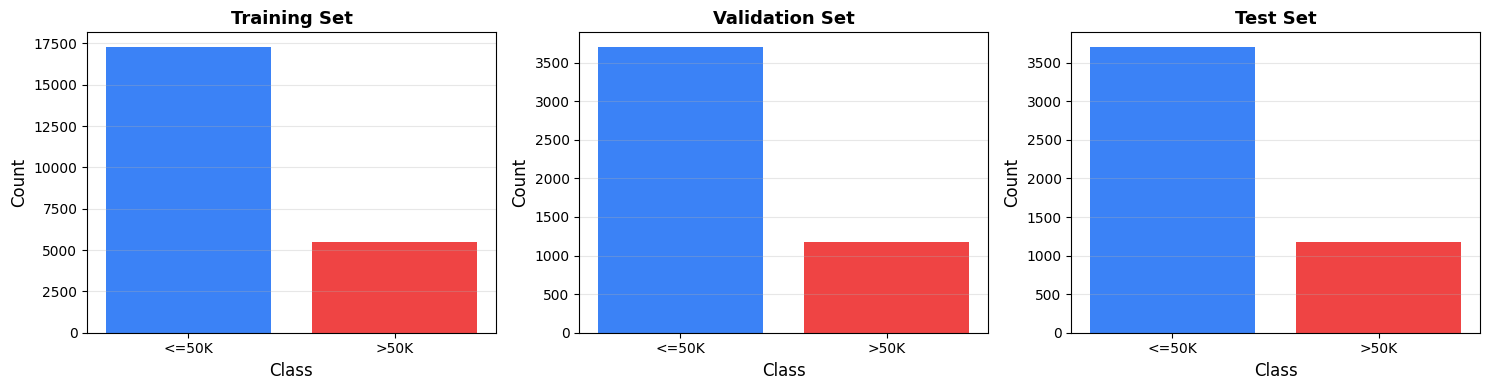

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for smple, (split_name, split_y) in enumerate([
    ("Training", y_train), 
    ("Validation", y_val), 
    ("Test", y_test)
]):
    counts = pd.Series(split_y).value_counts().sort_index()
    axes[smple].bar([0, 1], counts.values, color=['#3b82f6', '#ef4444'])
    axes[smple].set_xlabel('Class', fontsize=12)
    axes[smple].set_ylabel('Count', fontsize=12)
    axes[smple].set_title(f'{split_name} Set', fontsize=13, fontweight='bold')
    axes[smple].set_xticks([0, 1])
    axes[smple].set_xticklabels(['<=50K', '>50K'])
    axes[smple].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



# Test α values

In [20]:
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0]
my_naive_acc = []
best_alpha = None
best_nb_val_acc = 0

for alpha in alpha_values:
    my_naive_model = NaiveBayesClassifier(alpha=alpha)
    my_naive_model.fit(X_train, y_train)
    y_val_pred_nb = my_naive_model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred_nb)
    my_naive_acc.append(val_acc)
    print(f"Alpha={alpha:<5}  Val Accuracy={val_acc:.4f}")
    
    if val_acc > best_nb_val_acc:
        best_nb_val_acc = val_acc
        best_alpha = alpha

print(f"\nBest Alpha: {best_alpha} with validation accuracy: {best_nb_val_acc:.4f}")

Alpha=0.1    Val Accuracy=0.7963
Alpha=0.5    Val Accuracy=0.7965
Alpha=1.0    Val Accuracy=0.7963
Alpha=2.0    Val Accuracy=0.7965
Alpha=5.0    Val Accuracy=0.7944

Best Alpha: 0.5 with validation accuracy: 0.7965


# Test best α value

In [ ]:
X_train_final_nb = np.vstack((X_train, X_val))
y_train_final_nb = np.concatenate((y_train, y_val))

final_nb_model = NaiveBayesClassifier(alpha=best_alpha)
final_nb_model.fit(X_train_final_nb, y_train_final_nb)

y_test_pred_nb = final_nb_model.predict(X_test)

print(f"\nFinal Test Results (alpha={best_alpha}):")
print(f"Test Accuracy:    {accuracy_score(y_test, y_test_pred_nb):.4f}")
print(f"Precision:        {precision_score(y_test, y_test_pred_nb):.4f}")
print(f"Recall:           {recall_score(y_test, y_test_pred_nb):.4f}")
print(f"F1-Score:         {f1_score(y_test, y_test_pred_nb):.4f}")



Final Test Results (alpha=0.5):
Test Accuracy:    0.7945
Precision:        0.5545
Recall:           0.7440
F1-Score:         0.6354


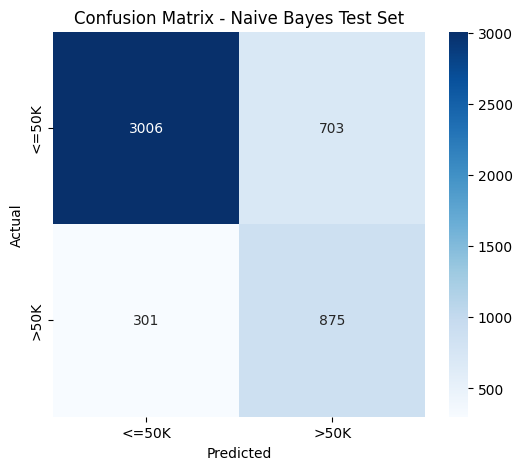

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred_nb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes Test Set')
plt.show()


# Trying Feature Selection

In [25]:
feature_subsets = {
    'All features': list(range(X_train.shape[1])),
    'Work-related': [0, 1, 3, 6],
    'Demographic': [4, 5, 6, 7],
    'My_spread': [0, 1, 2, 3]
}

print("\nImpact of different feature paart :")
for subset_groupeNAme, features in feature_subsets.items():
    X_train_subset = X_train[:, features]
    X_val_subset = X_val[:, features]
    
    model = NaiveBayesClassifier(alpha=best_alpha)
    model.fit(X_train_subset, y_train)
    
    y_pred = model.predict(X_val_subset)
    acc = accuracy_score(y_val, y_pred)
    print(f"{subset_groupeNAme:<20} Val Accuracy: {acc:.4f}")


Impact of different feature paart :
All features         Val Accuracy: 0.7965
Work-related         Val Accuracy: 0.7826
Demographic          Val Accuracy: 0.7361
My_spread            Val Accuracy: 0.8225


In [34]:
y_probs = final_nb_model.predict_proba(X_test)
max_probs = np.max(y_probs, axis=1)

print("\nPredicted Probability Statistics:")
print(f"Mean max probability: {np.mean(max_probs):.4f}")
print(f"Median max probability: {np.median(max_probs):.4f}")
print(f"Min max probability: {np.min(max_probs):.4f}")
print(f"Max max probability: {np.max(max_probs):.4f}")

high_conf = np.sum(max_probs > 0.9)
med_conf = np.sum((max_probs > 0.7) & (max_probs <= 0.9))
low_conf = np.sum(max_probs <= 0.7)

print(f"High confidence (>0.9): {high_conf} samples ({high_conf/len(max_probs)*100:.1f}%)")
print(f"Medium confidence (0.7-0.9): {med_conf} samples ({med_conf/len(max_probs)*100:.1f}%)")
print(f"Low confidence (<=0.7): {low_conf} samples ({low_conf/len(max_probs)*100:.1f}%)")



print("\nDiscussion My Point of Vieeeeeew:")
print("Naive Bayes assumes P(x|y) = Π P(x_i|y), meaning features are conditionally independent.")
print("In the Adult dataset, features like Education and Occupation, or Marital-status and Relationship,\nare correlated, violating this assumption. Despite this, Naive Bayes still performs reasonably well.")
print("\n This dataset Haves some correlated features\n which impacts the performance of Naive Bayes classifier due to its independence assumption.")




Predicted Probability Statistics:
Mean max probability: 0.8827
Median max probability: 0.9656
Min max probability: 0.5006
Max max probability: 1.0000
High confidence (>0.9): 3090 samples (63.3%)
Medium confidence (0.7-0.9): 948 samples (19.4%)
Low confidence (<=0.7): 847 samples (17.3%)

Discussion My Point of Vieeeeeew:
Naive Bayes assumes P(x|y) = Π P(x_i|y), meaning features are conditionally independent.
In the Adult dataset, features like Education and Occupation, or Marital-status and Relationship,
are correlated, violating this assumption. Despite this, Naive Bayes still performs reasonably well.

 This dataset Haves some correlated features
 which impacts the performance of Naive Bayes classifier due to its independence assumption.


In [35]:
from IPython.display import Markdown

display(Markdown("# Performance Comparison between My best Naive Bayes in the world and sklearn's MultinomialNB(too weak,,I won)"))

# Performance Comparison between My best Naive Bayes in the world and sklearn's MultinomialNB(too weak,,I won)

In [18]:
sklearn_nb = MultinomialNB(alpha=best_alpha)
sklearn_nb.fit(X_train_final_nb, y_train_final_nb)
y_pred_sklearn = sklearn_nb.predict(X_test)

print("\nComparison with sklearn's MultinomialNB:")
print(f"Our Implementation Accuracy: {accuracy_score(y_test, y_test_pred_nb):.4f}")
print(f"sklearn MultinomialNB Accuracy: {accuracy_score(y_test, y_pred_sklearn):.4f}")



Comparison with sklearn's MultinomialNB:
Our Implementation Accuracy: 0.7945
sklearn MultinomialNB Accuracy: 0.7462
